# 1. 베이지안 추론의 철학


## 1.2 베이지안 프레임워크

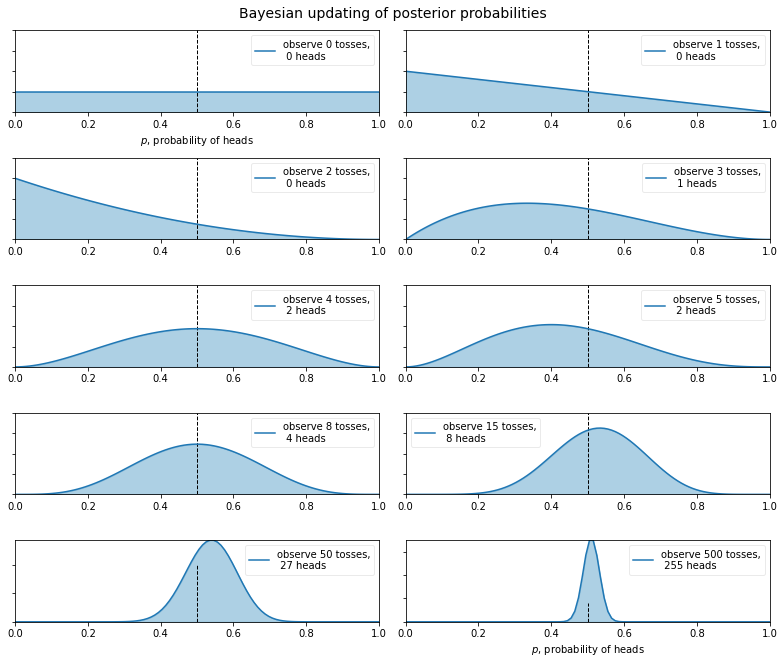

In [1]:
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)

"""

# The code below can be passed over, as it is currently not important, plus it
# uses advanced topics we have not covered yet. LOOK AT PICTURE, MICHAEL!
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)//2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

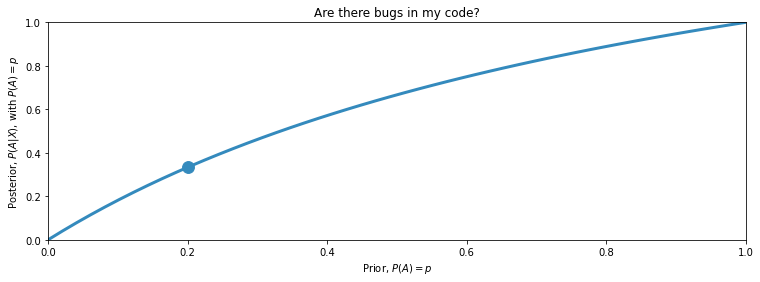

In [2]:
figsize(12.5, 4)
p = np.linspace(0, 1, 50)
plt.plot(p, 2*p/(1+p), color="#348ABD", lw=3)
#plt.fill_between(p, 2*p/(1+p), alpha=.5, facecolor=["#A60628"])
plt.scatter(0.2, 2*(0.2)/1.2, s=140, c="#348ABD")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Prior, $P(A) = p$")
plt.ylabel("Posterior, $P(A|X)$, with $P(A) = p$")
plt.title("Are there bugs in my code?");

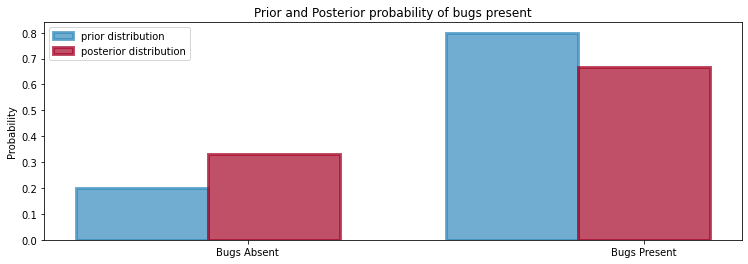

In [3]:
figsize(12.5, 4)
colours = ["#348ABD", "#A60628"]

prior = [0.20, 0.80]
posterior = [1./3, 2./3]
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
        color=colours[0], label="prior distribution",
        lw="3", edgecolor=colours[0])

plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7,
        width=0.25, color=colours[1],
        label="posterior distribution",
        lw="3", edgecolor=colours[1])

plt.xticks([0.20, .95], ["Bugs Absent", "Bugs Present"])
plt.title("Prior and Posterior probability of bugs present")
plt.ylabel("Probability")
plt.legend(loc="upper left");

## 1.3 확률분포


### 1.3.1 이산적인 경우

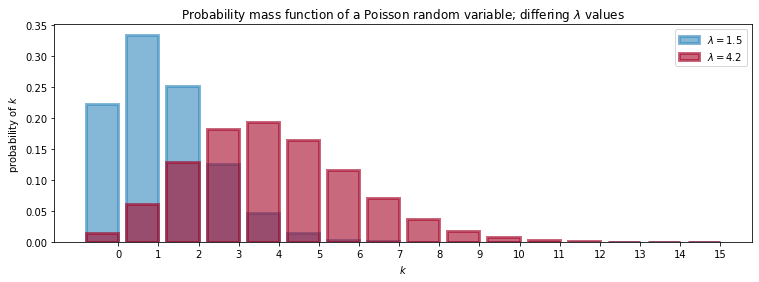

In [4]:
figsize(12.5, 4)

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values");

### 1.3.2 연속적인 경우

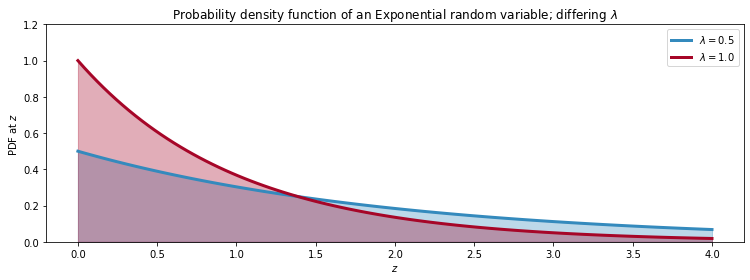

In [5]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

## 1.4 컴퓨터를 사용하여 베이지안 추론하기

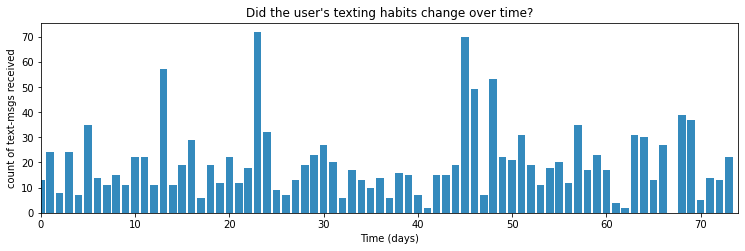

In [8]:
figsize(12.5, 3.5)
count_data = np.loadtxt("/content/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

### 1.4.2 우리의 첫 번째 망치를 소개한다: PyMC

In [9]:
import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [10]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [11]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [12]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 14 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [13]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

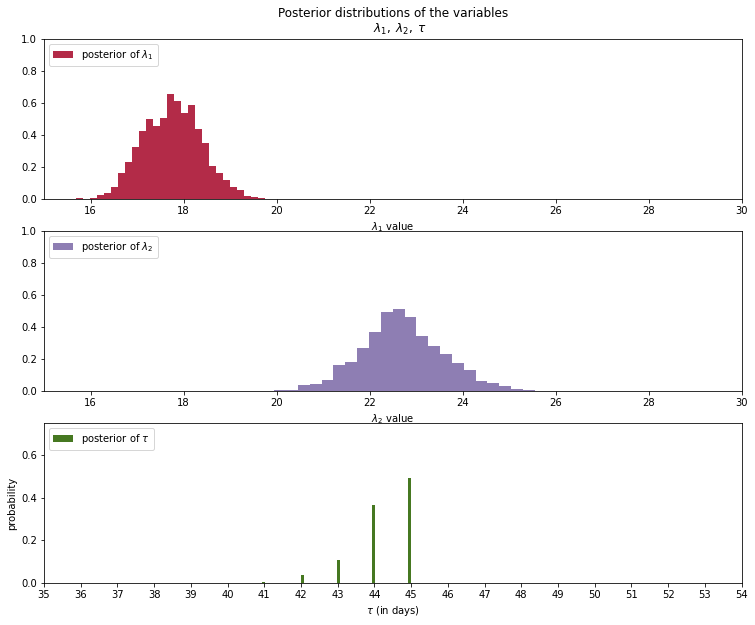

In [14]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### 1.4.4 사후확률분포에서서 얻은 표본에는 어떤 좋은 점이 있는가?

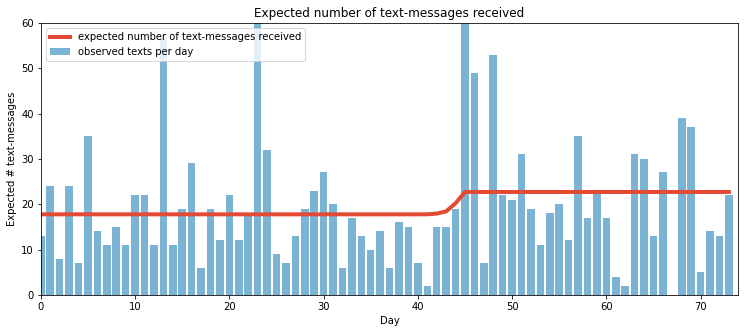

In [15]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");